In [52]:
import trusspy as tp
import networkx as nx
import itertools
import math
from numpy import random
%matplotlib inline
import matplotlib.pyplot as plt
#matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [53]:
MAX_LENGTH = 4
SQUARE_SIZE=4
LAYER_HEIGHT=5
MUTATION_ADD=5

def create_individual(nbr_layers, mu=6, sigma=0.7):
    """
    Create an individual 
    An individual is a list of 4 layer, each layer is a list containing tuple for representing marhsmallow position
    example : 
    one_individual = [ 
    [(1,1), (2,3), (5,6)], 
    [(1,1), (2,3), (5,6), (2,3), (5,6)], 
    [(1,1), (2,3), (5,6), (2,3), (5,6), (2,3), (5,6)], 
    [(1,1), (2,3)] 
    ]


    """
    individual = [[ tuple((round(SQUARE_SIZE*random.normal(0.5,0.2)) , round(SQUARE_SIZE*random.normal(0.5,0.2)), layer*LAYER_HEIGHT)) for _ in range(round(random.normal(mu,sigma)))] for layer in range(nbr_layers)]
    return individual


def create_initial_population(nbr_ind, nbr_layers, mu=5, sigma=1):
    """
    Generate an initial population of spaghetti marshmallow towers

    Input : 
    nbr_ind : the number of towers (individuals) in this initial generation
    nbr_layers : the number of layers in each tower
    mu : Mean for gaussian distribution of number of marshmallow in each layer
    sigma : Sigma for gaussian distribution of number of marshmallow in each layer
    
    Output:
    A list of individual
    An individual is a list of layers, each layer is a list containing tuple for representing marhsmallow position
    
    
    """
    population = [  create_individual(nbr_layers, mu, sigma)   for _ in range(nbr_ind) ]
    return population


def generate_graph(individual):
    """
    Generate a networkx graph from an individual

    Input:
    An individual

    Output :
    A networkx graph 
    """
    G = nx.Graph()
    nbr_layers = len(individual)
    for layer in range(nbr_layers):
        G.add_nodes_from(individual[layer]) #we add this layer to the graph 
        potential_spaghetti = list(itertools.combinations(individual[layer],2))
        if layer < nbr_layers - 1:
            potential_spaghetti += list(itertools.product(individual[layer], individual[layer+1])) #we add spaghetti between levels


        for potential_spaghetto in potential_spaghetti:
            length = math.sqrt((potential_spaghetto[0][0] - potential_spaghetto[1][0])**2 + (potential_spaghetto[0][1] - potential_spaghetto[1][1])**2)
            if length < MAX_LENGTH:
                G.add_edge(potential_spaghetto[0], potential_spaghetto[1])

    return G





def check_connectivity(graph):
    """
    Check if there is only one tower, i.e from any marshallow we can reach any other marshallow, i.e., the graph is connected. 

    Input:
    a graph corresponding to an individual

    Output:
    The degree of connectivity, i.e. the smallest number of connection a marshmallow have
    """     

    degree_sequence = (d for n, d in graph.degree())
    print(degree_sequence)
    return min(degree_sequence)


def draw_tower(graph):
    x, y, z = zip(*list(graph.nodes()))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x, y, z, c=z, cmap='seismic', linewidths=10, alpha=1)
    for edge in list(graph.edges()):
        x_ed, y_ed, z_ed = zip(*list(edge))
        ax.plot(x_ed,y_ed,z_ed, c="#FFBB00")
    plt.show()
    fig.savefig("model_undeformed_inc0_3d.png")


In [54]:
def Compute_fitness_value(population,array_max_force):
    """ 
    Gives the fitness value for each graph 

    input: list of connected graphs 

    output: list of fitness values associated to each graphs
    
    """
    fitness_value =[]
    for i in range(len(population)) :
        fitness_value[i] = array_max_force[i]*len(population[i])

    return fitness_value


In [55]:
population = create_initial_population(10,4)
population
G=generate_graph(population[1])
print(population[1])

In [56]:
population_list=population[1][0]+population[1][1]+population[1][2]+population[1][3]

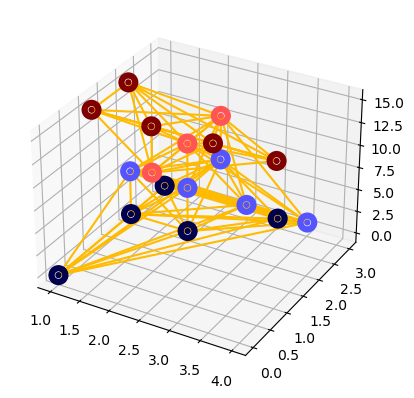

In [57]:
draw_tower(G)


In [58]:
check_connectivity(G)
list(G.nodes()).index(list(G.nodes())[1])

1

In [65]:
# init model
M = tp.Model(logfile=True)

with M.Nodes as MN:
    for i in range(len(population_list)):
            MN.add_node(i+1, coord=population_list[i])

element_type   = 1    # truss
material_type  = 1    # linear-elastic

youngs_modulus = 4*10**9
cross_section_area = math.pi*(1.25*10**(-3))**2

with M.Elements as ME:
    for i in range(len(list(G.edges()))):
        ME.add_element( i+1, conn=(population_list.index(list(G.edges())[i][0])+1,population_list.index(list(G.edges())[i][1])+1) )
    ME.assign_etype("all", element_type)
    ME.assign_mtype("all", material_type)
    ME.assign_material("all", [youngs_modulus])
    ME.assign_geometry("all", [cross_section_area])

with M.Boundaries as MB:
    for i in range(len(population_list)):
        if population_list[i][2]==0:
            MB.add_bound_U( i+1, (0,0,0) )
    else: MB.add_bound_U( i+1, (1,1,1) )
    
with M.ExtForces as MF:
    for i in range(len(population_list)):
        if population_list[i][2]==15:
            MF.add_force( i+1, ( 0, 0,-1) )
        else:MF.add_force( i+1, ( 0, 0,0) )

M.Settings.dlpf = 0.01*5
M.Settings.du = 0.1/8
M.Settings.incs = 163
M.Settings.stepcontrol = True
M.Settings.maxfac = 4

M.Settings.ftol = 8
M.Settings.xtol = 8
M.Settings.nfev = 8

M.Settings.dxtol = 1.25

M.build()
M.run()

RuntimeError: failed to factorize matrix at line 110 in file /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_73mihr4w88/croot/scipy_1675459119684/work/scipy/sparse/linalg/_dsolve/SuperLU/SRC/dsnode_bmod.c


<Figure size 640x480 with 0 Axes>

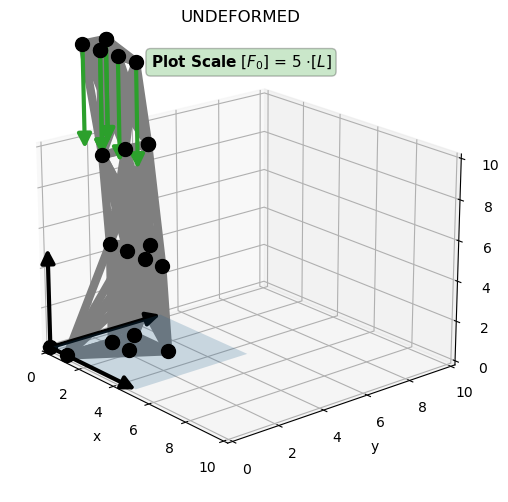

In [66]:
# undeformed views
fig, ax = M.plot_model(
    view="3d",  # 'xy', 'yz', 'xz'
    contour="force",
    lim_scale=(0, 10, 0, 10, 0, 10),  # 3d
    # lim_scale=1.4, # plane-view
    force_scale=5.0,  # 2
    inc=0,
)
plt.show()

In [ ]:
population_list


In [ ]:
list(G.edges())[1][0]

In [ ]:
population_list.index(list(G.edges())[1][0])+1

In [ ]:
population_list=population[1][0]+population[1][1]+population[1][2]+population[1][3]



In [ ]:
population_array

In [ ]:
pop_list

In [ ]:
tuple(G.edges)

In [ ]:
tuple(G.nodes)[0]

In [ ]:
tuple(population_list).index(list(G.edges())[1][0])

In [ ]:
list(population_list[1]).index(2)

In [ ]:
population

In [ ]:
population_array.tolist()